In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils

import xgboost as xgb
import shap
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy.stats import zscore, binned_statistic
from scipy.ndimage import gaussian_filter1d

from hyperopt.pyll.stochastic import sample
from timeit import default_timer as timer
from hyperopt import tpe, Trials, fmin, hp, STATUS_OK

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# load
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

wtt = utils.load_adata(os.path.join(pdfp, 'mouse_wt_imputed.h5ad'))
mutt = utils.load_adata(os.path.join(pdfp, 'mouse_sca1_imputed.h5ad'))


loaded @200717.14:57:09
took 64.63-s to load data
loaded @200717.14:58:10
took 61.28-s to load data


Trying to set attribute `.obs` of view, copying.



Starting Purkinje cell
----



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


Trying to set attribute `.obs` of view, copying.



... done evaluating Purkinje cell.
      took 0.9624780297279358-min

Starting Oligodendrocyte progenitor cell
----



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)

... done evaluating Oligodendrocyte progenitor cell.
      took 0.5068848252296447-min

Starting Oligodendrocyte
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:01:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:57)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)

... done evaluating Oligodendrocyte.
      took 2.600235176086426-min


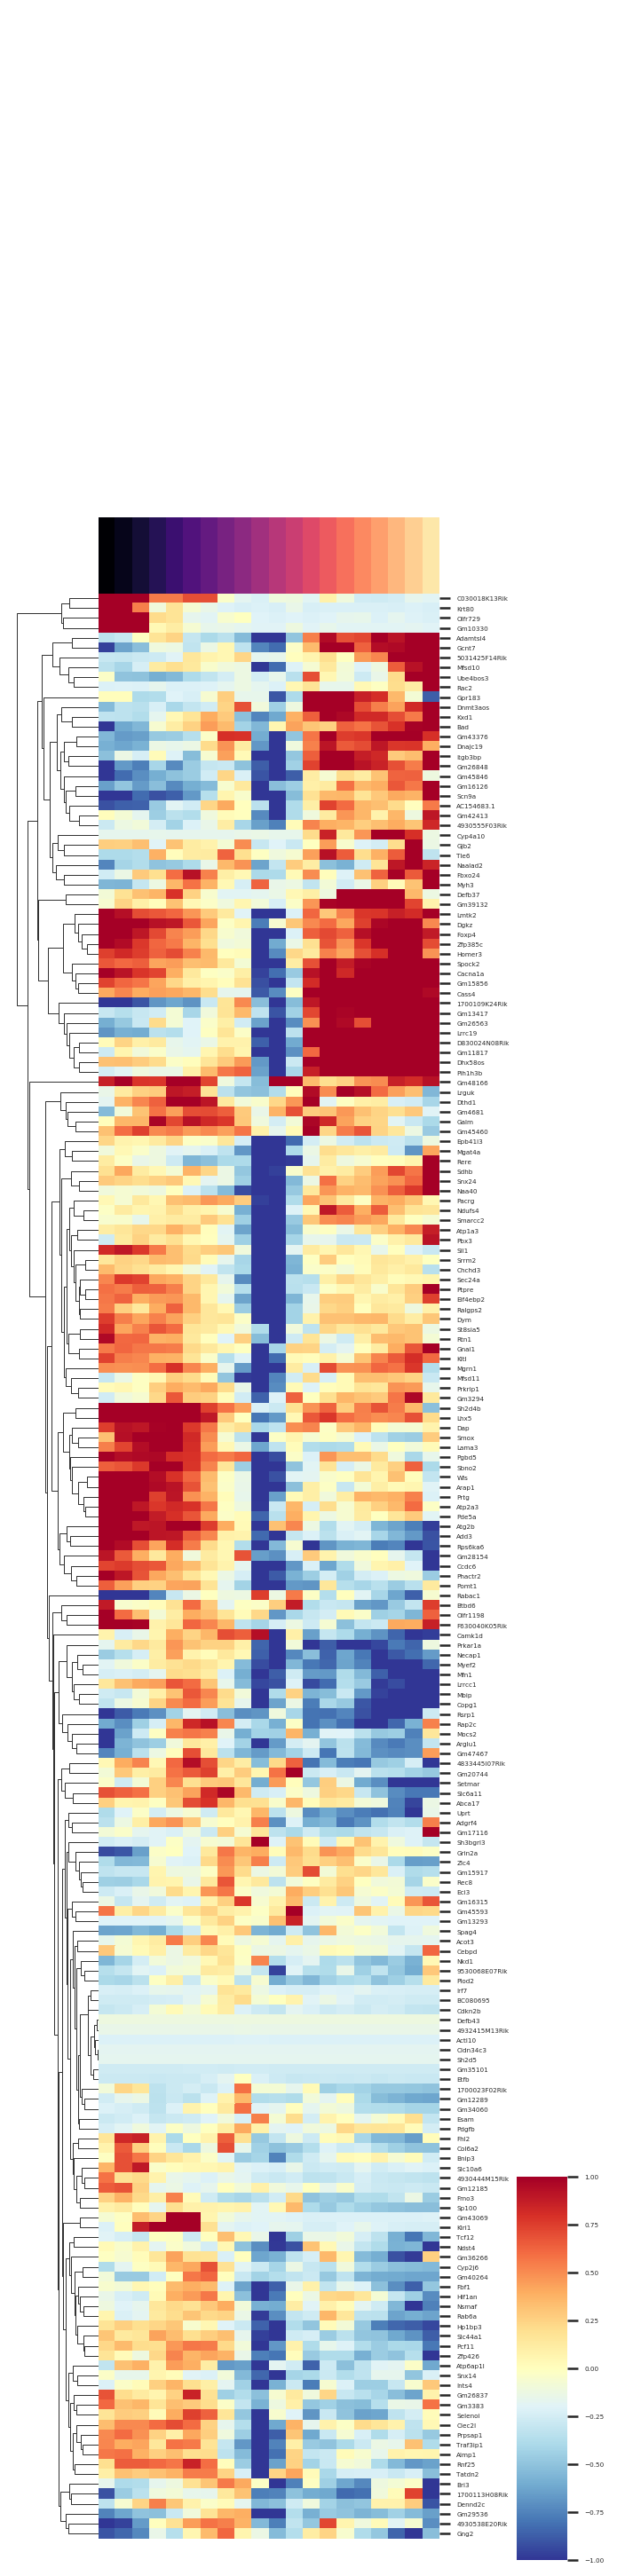

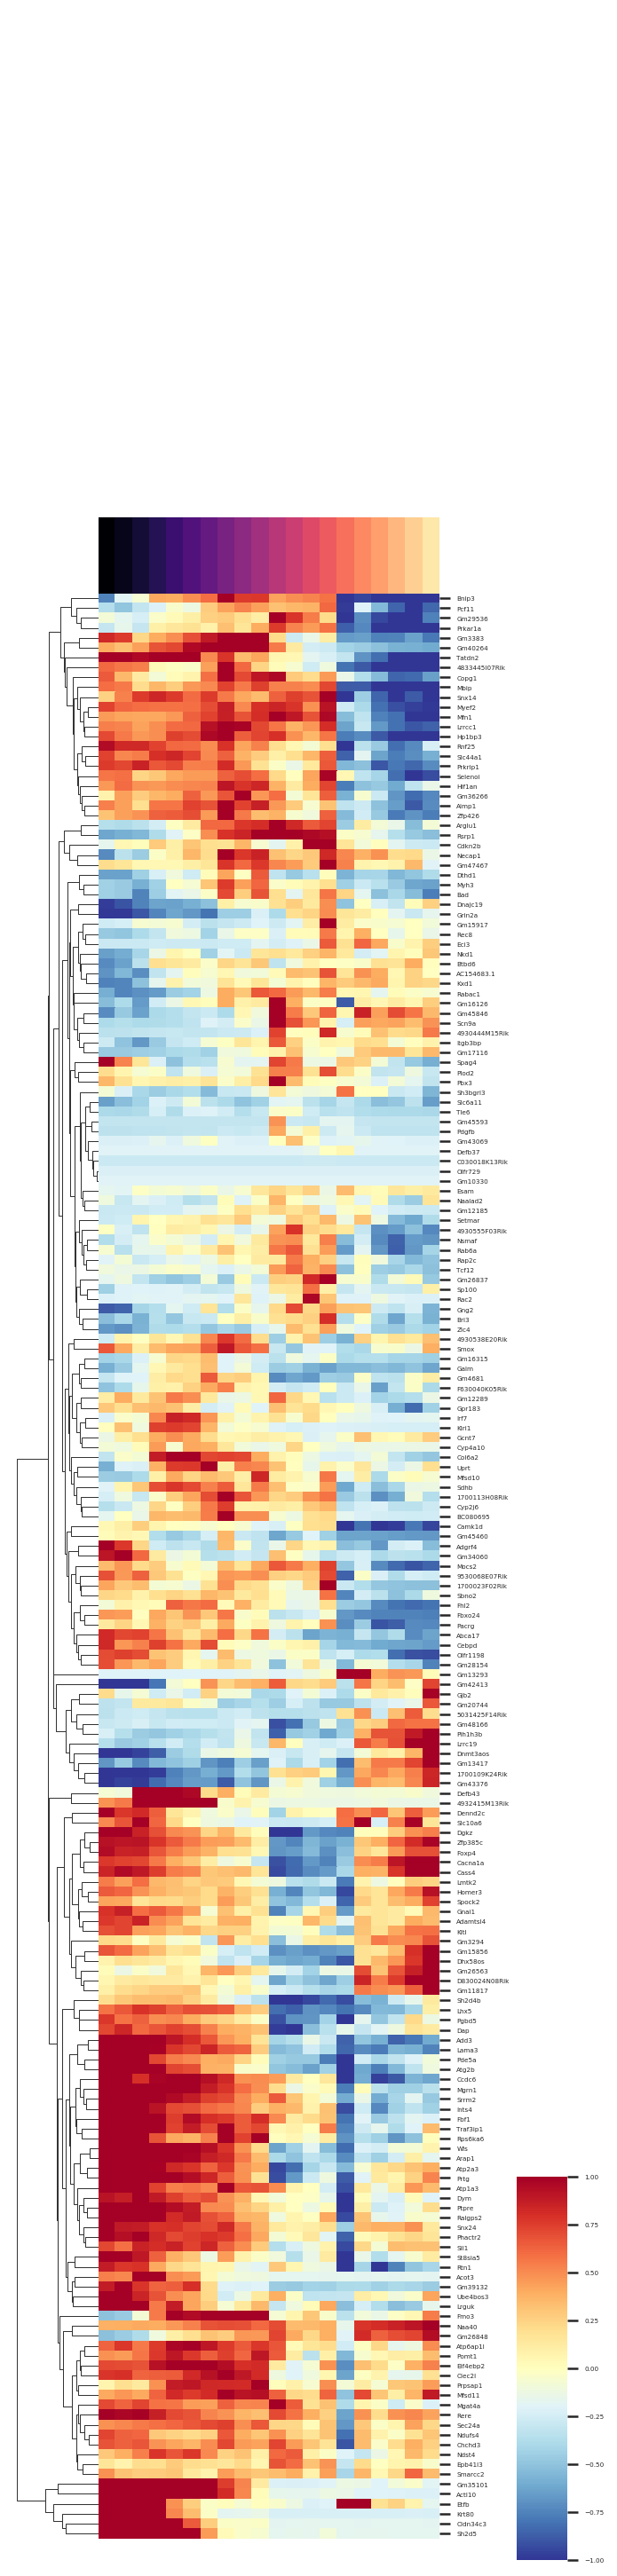

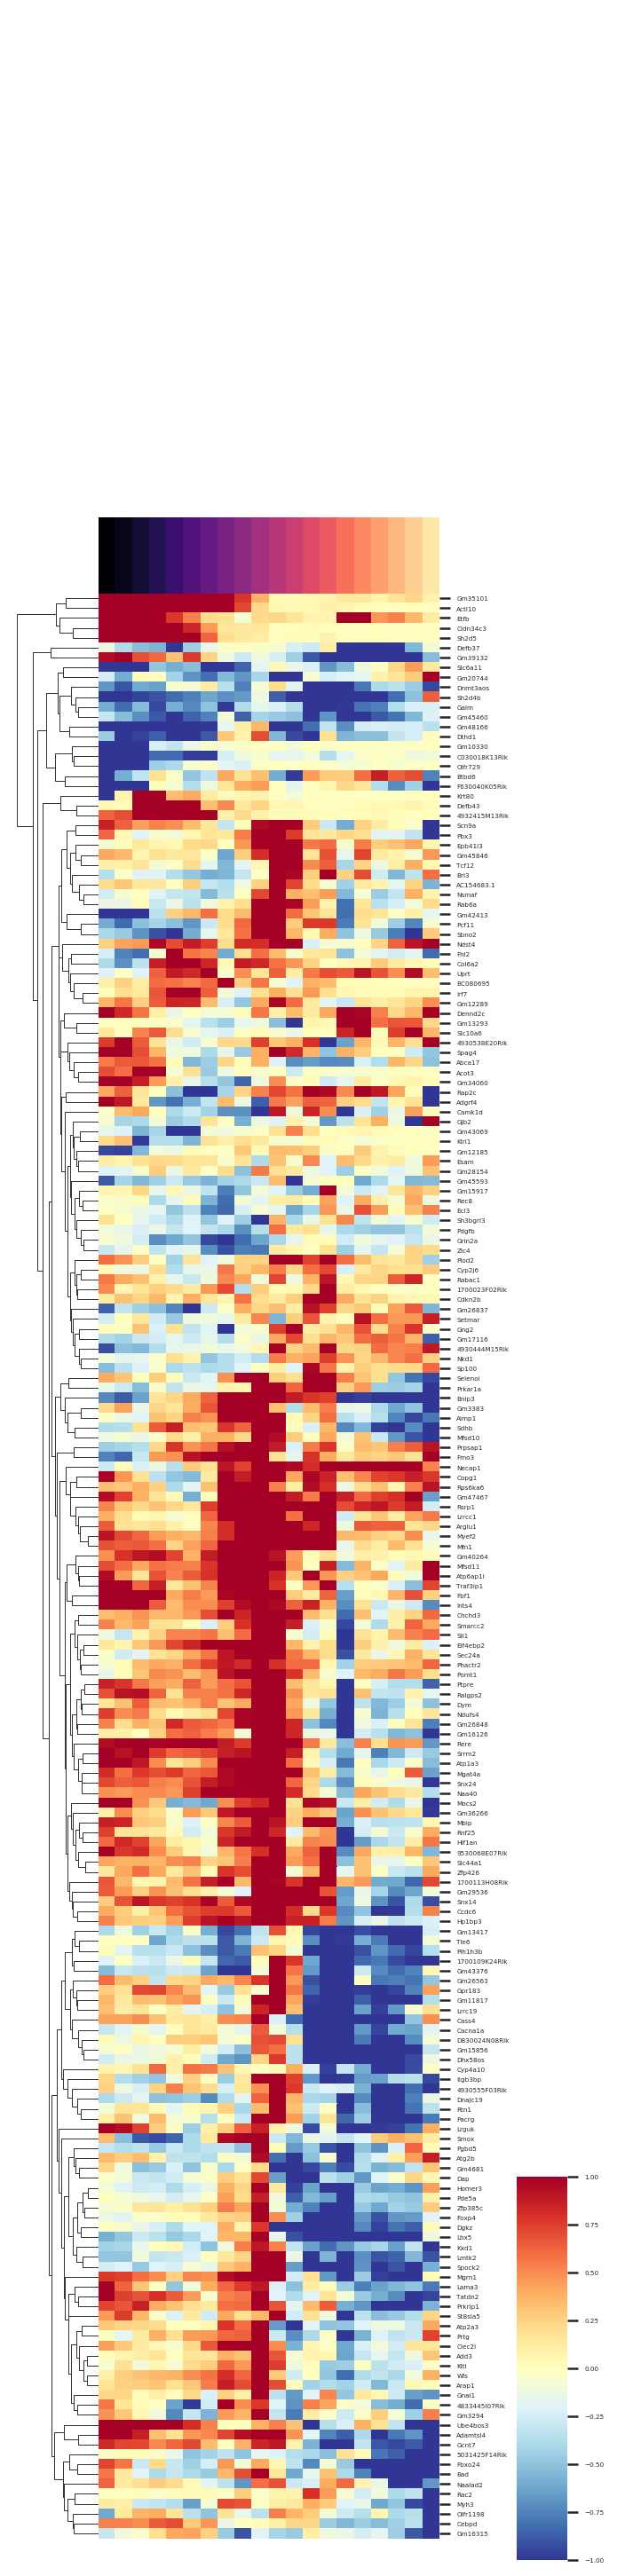

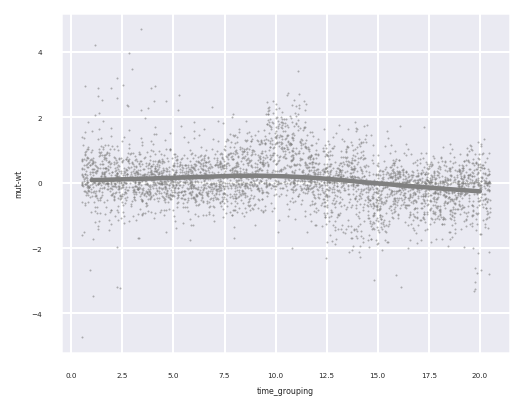

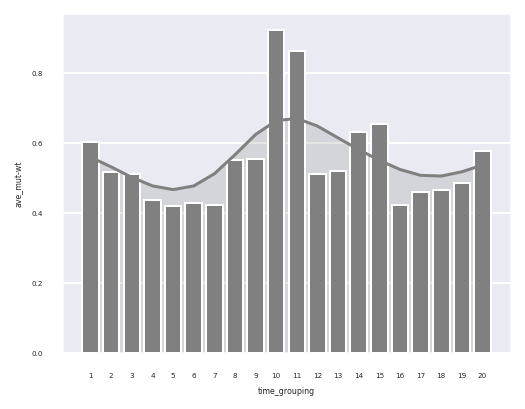

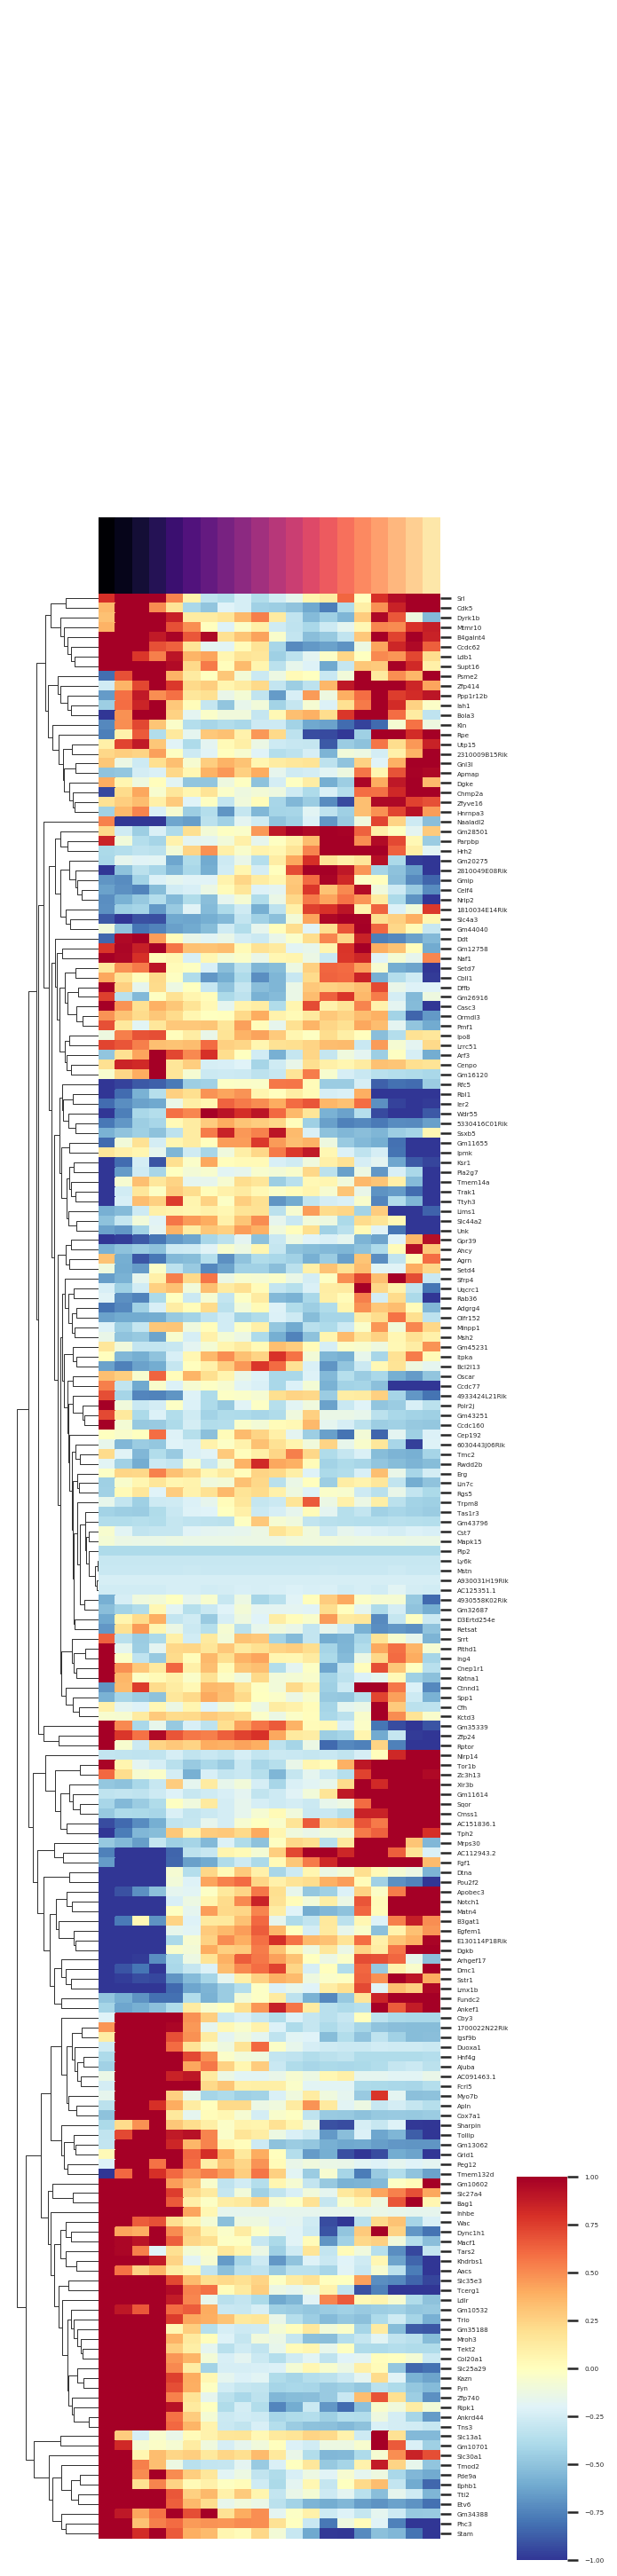

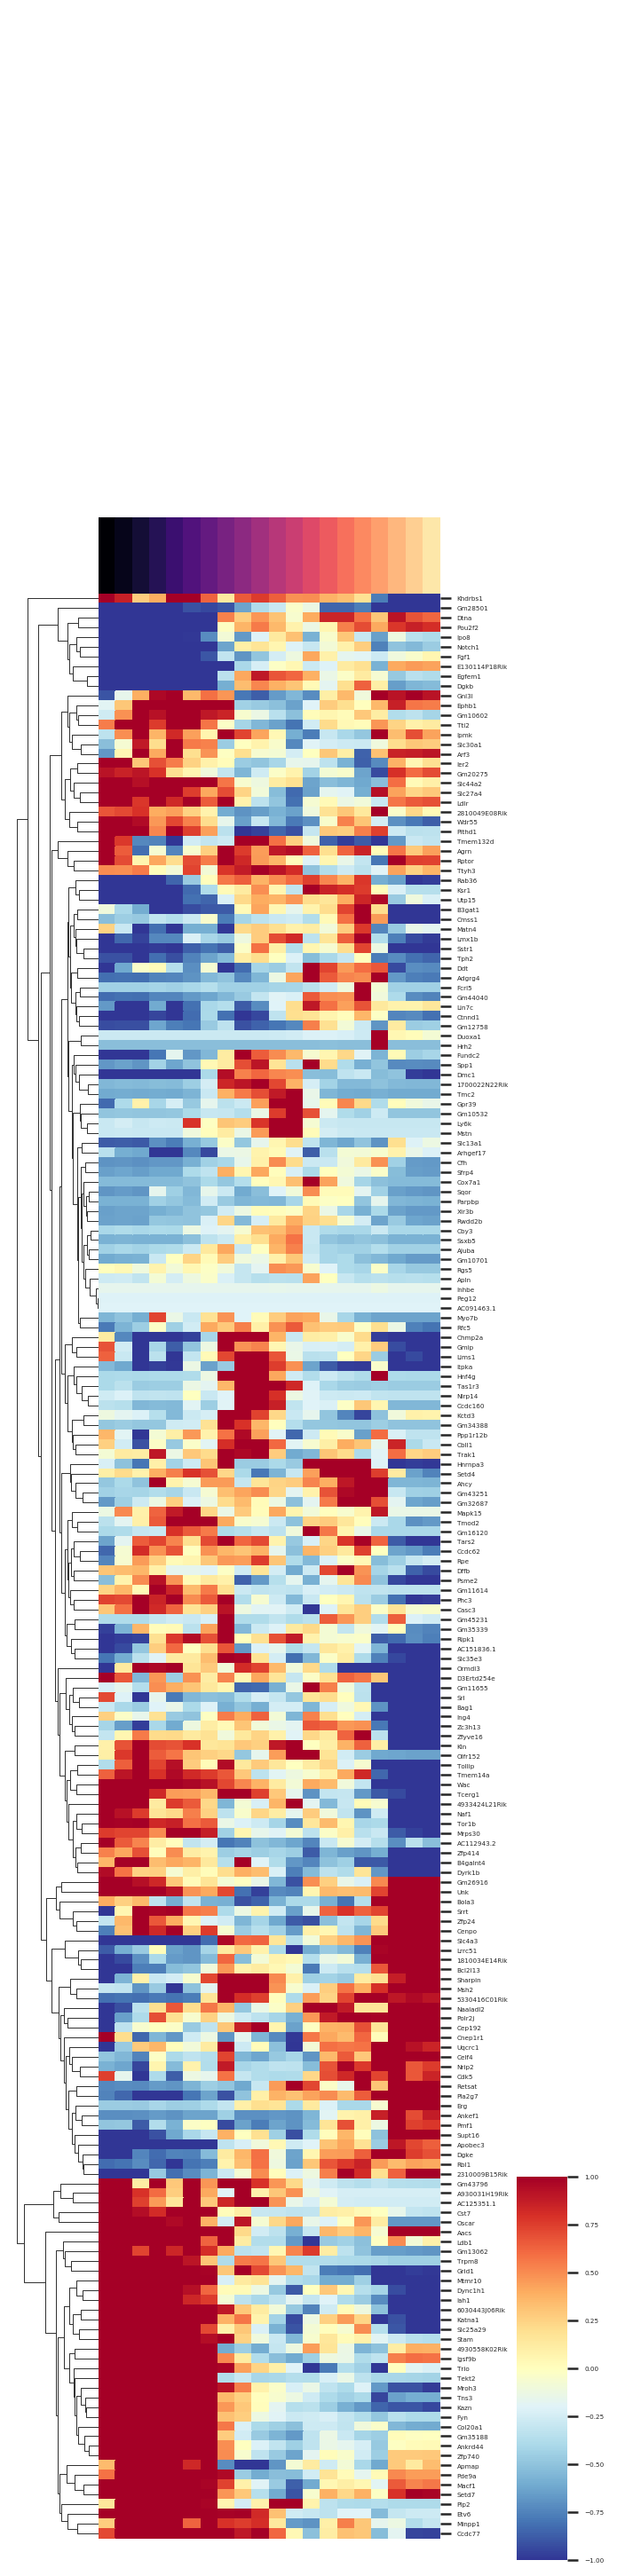

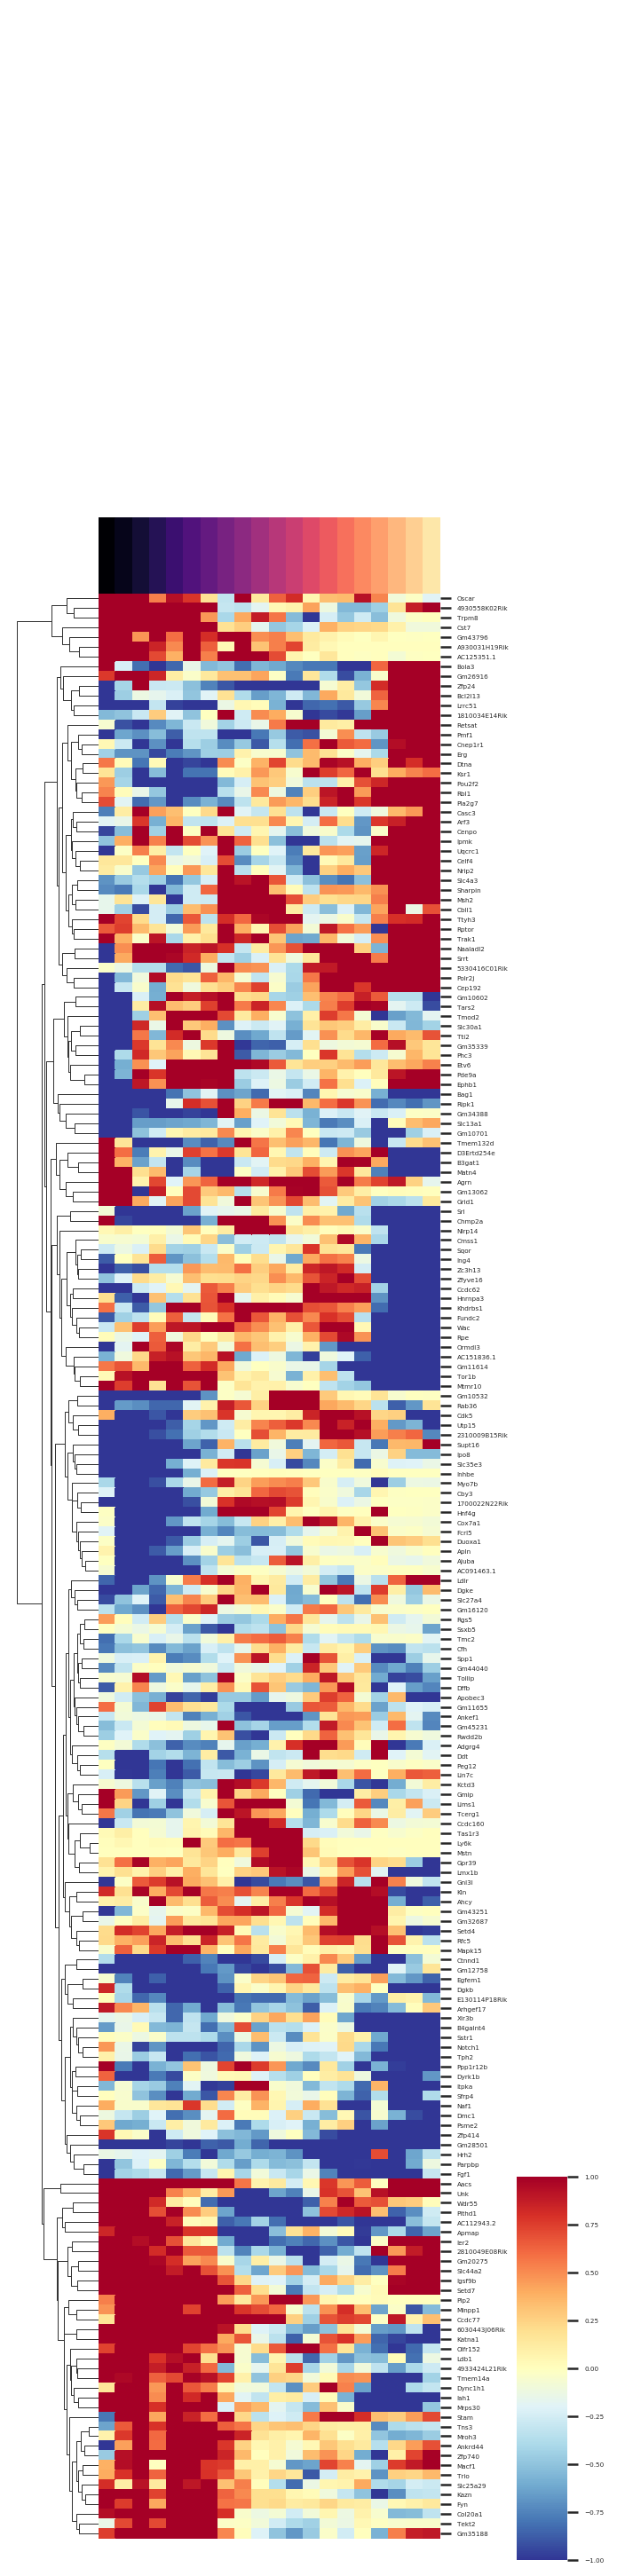

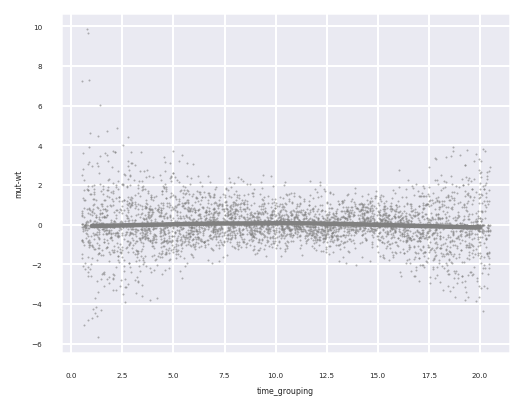

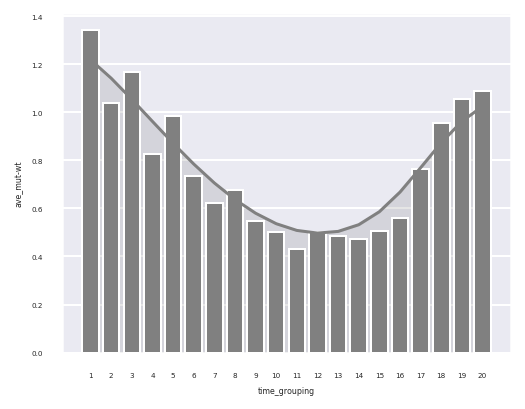

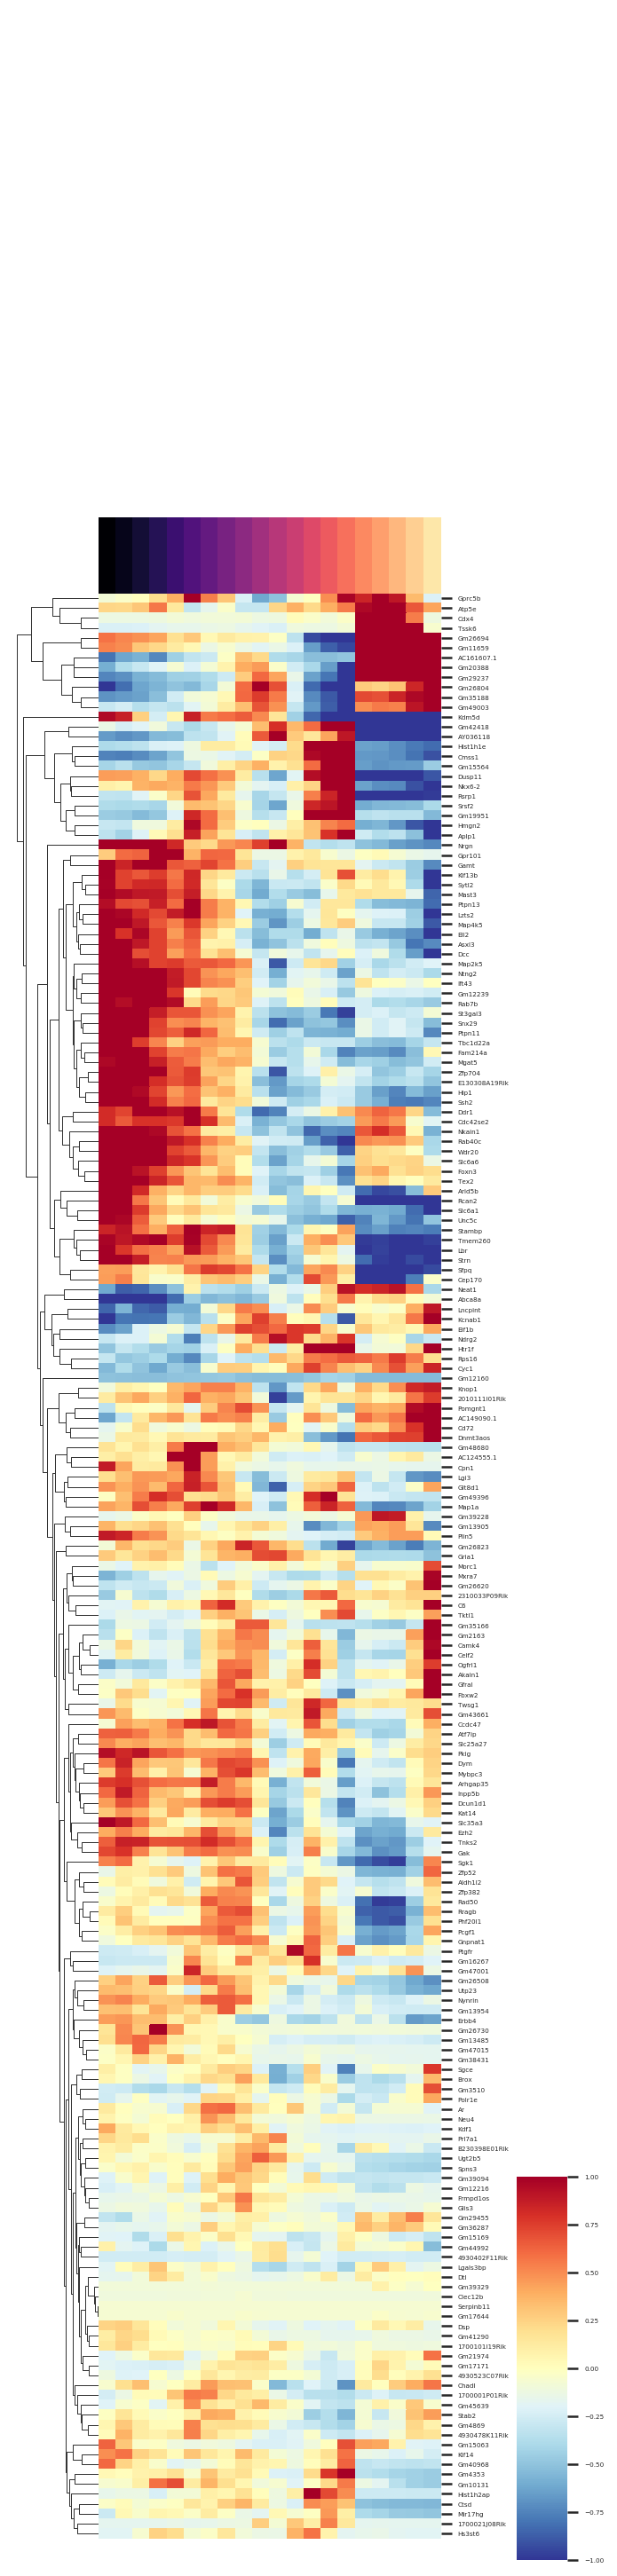

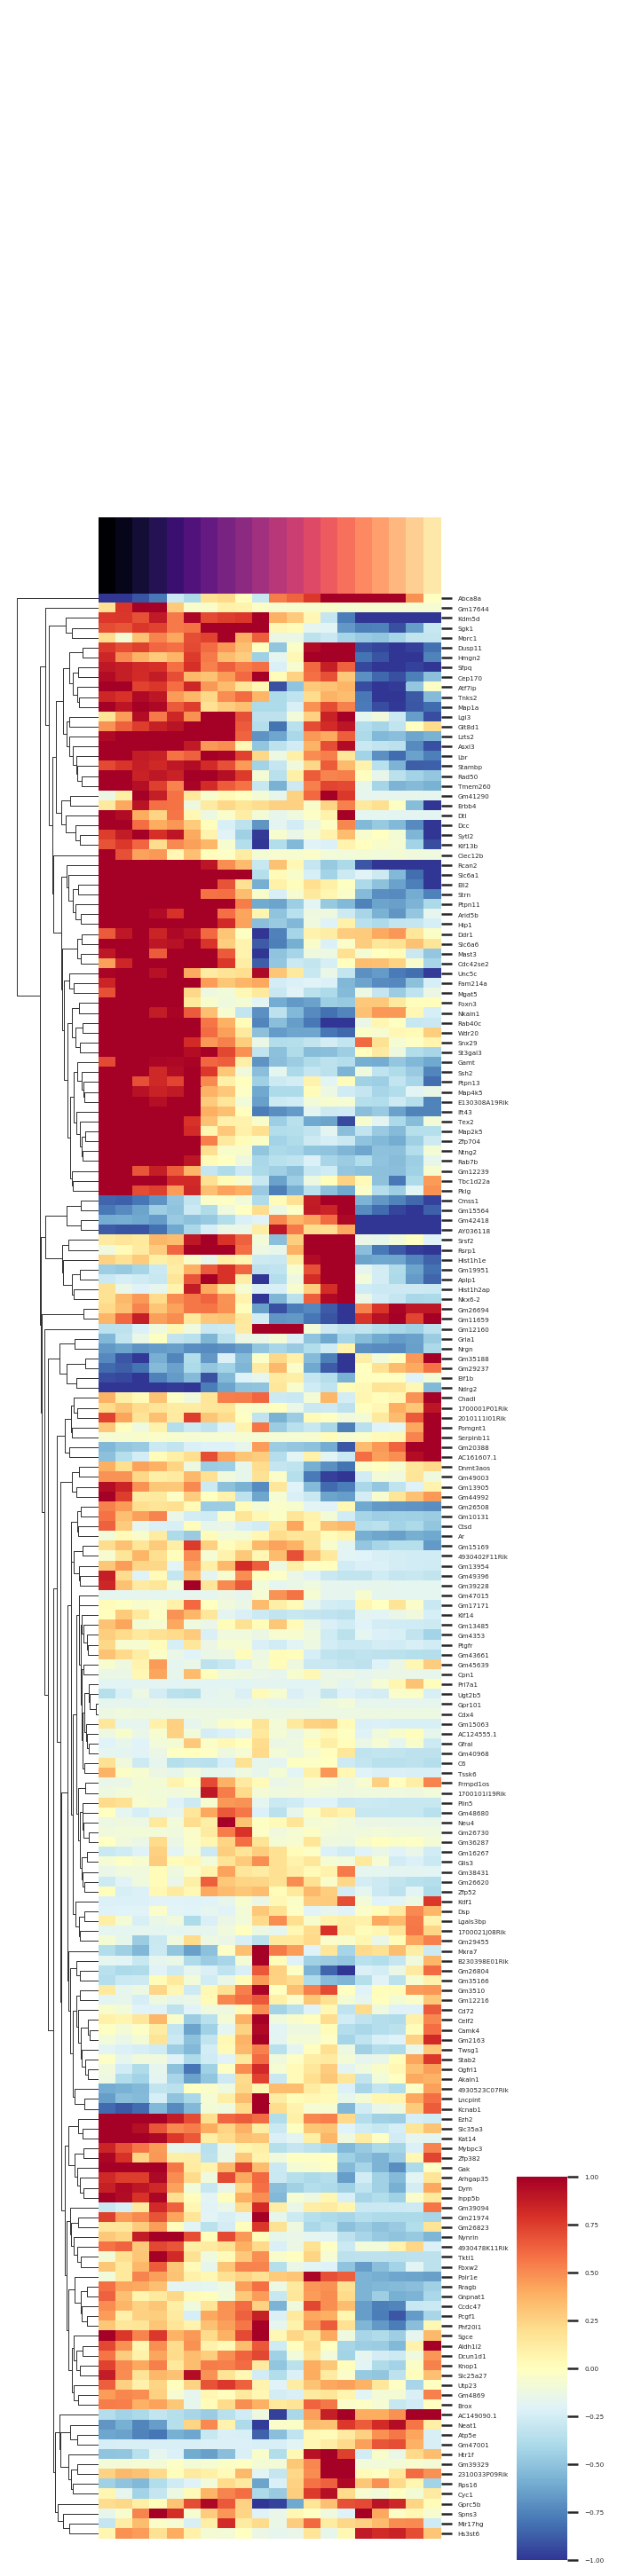

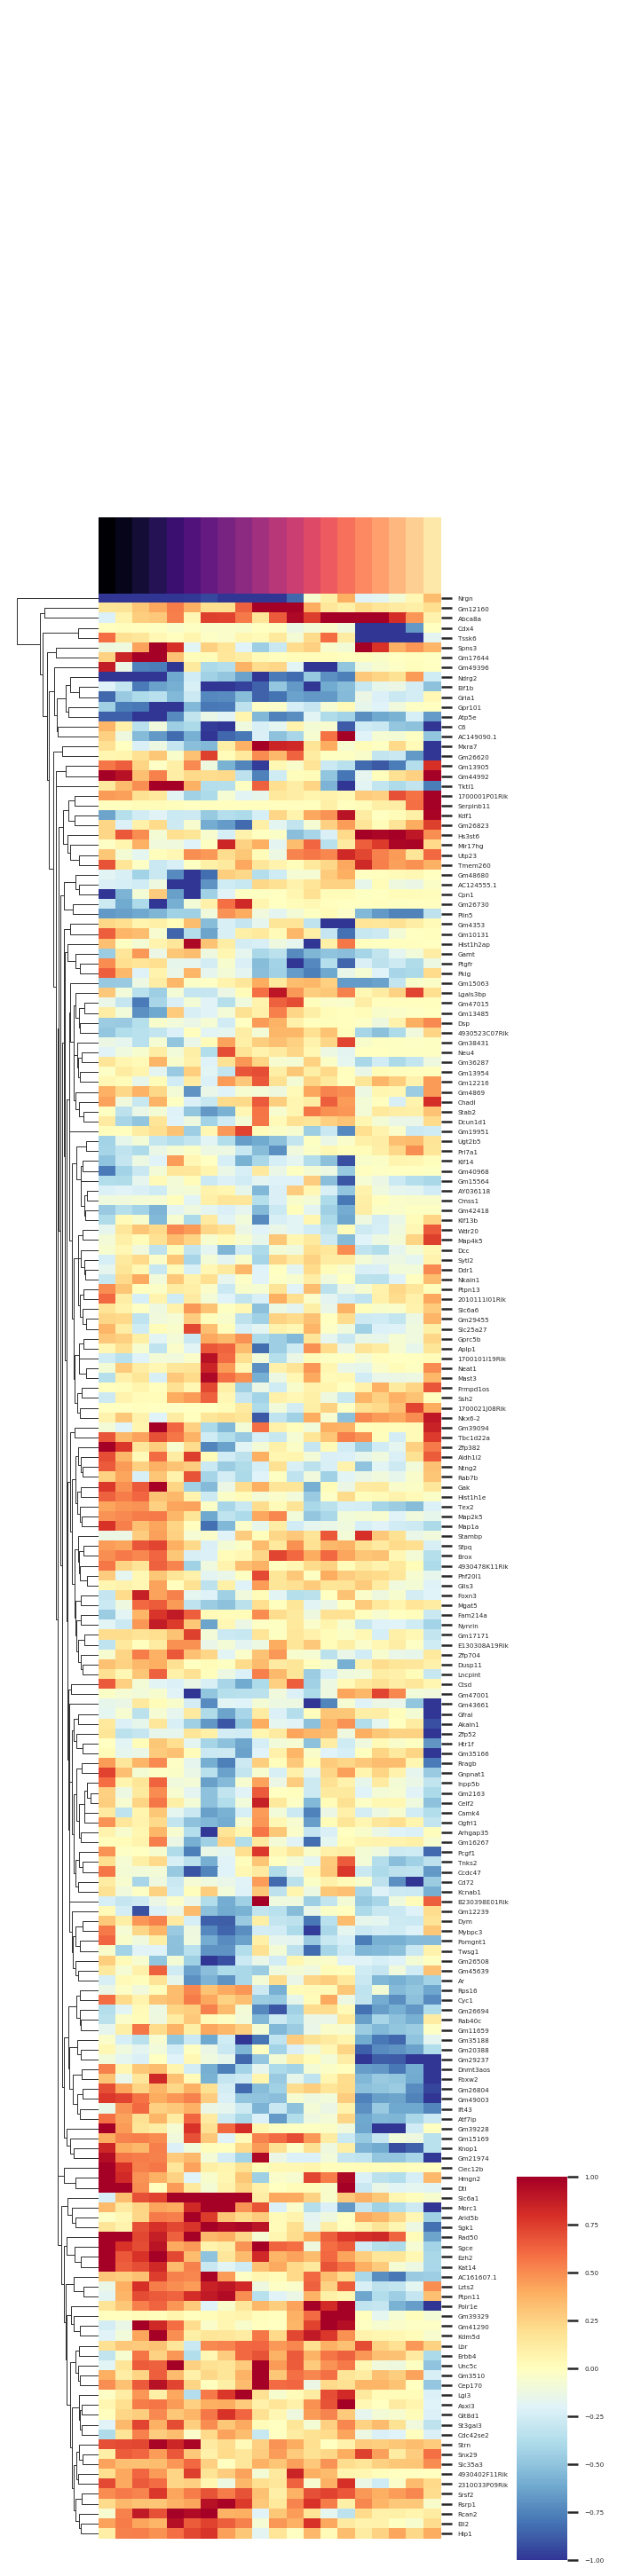

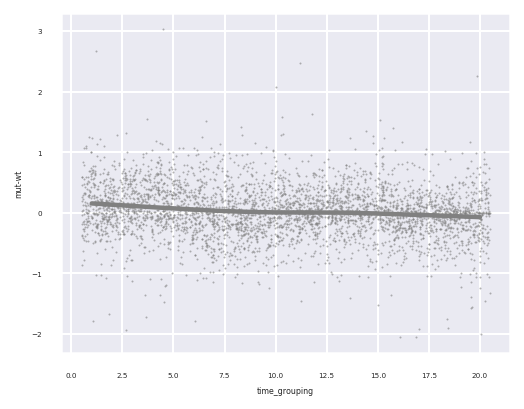

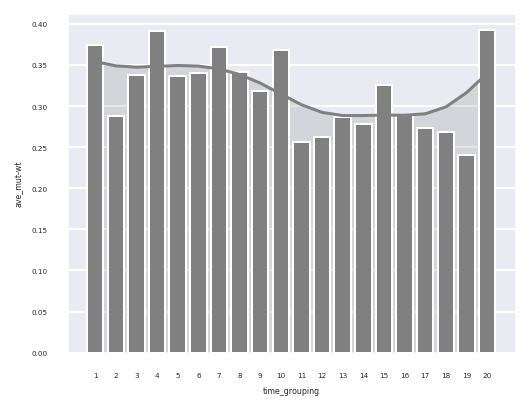

In [8]:

# get the data
sns.set(font_scale=0.33)
ntop = 100
ntimebins = 20
n_bootstraps = 1 
verbose = True


mito_genes = [i for i in wtt.var_names if i.startswith('mt-')]
results = pd.DataFrame()
performance = pd.DataFrame()
for ii, ctype in enumerate(['Purkinje cell', 'Oligodendrocyte progenitor cell',
                            'Oligodendrocyte', ]):
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['ctype']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['ctype']==ctype), :]
            mut.obs['value'] = 0

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        if False:
            wt = utils.adata_phate(wt)
            mut = utils.adata_phate(mut)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        
        # strata
        X = pd.DataFrame(wt.layers['imputed'], columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()

    # from files 
    topgenes = pd.read_csv(os.path.join(pfp, 'top{}_dyngenes_v3.csv'.format(ntop)), index_col=0)
    wttop = topgenes.loc[((topgenes['ctype']==ctype) & (topgenes['top_wt']==1)), 'index'].to_list()
    muttop = topgenes.loc[((topgenes['ctype']==ctype) & (topgenes['top_mut']==1)), 'index'].to_list()
    topgenes = topgenes.loc[topgenes['ctype']==ctype, 'index'].to_list()

    # topn, specify how to normalize
    norm_ctypeANDcondition = False
    
    if norm_ctypeANDcondition: # plot both for now
        x = pd.DataFrame(wt[:, topgenes].X.todense(), columns=topgenes)
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])
        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}.png'.format(ctype)))

        # plot same genes in mut
        mut_goi = x.index[p.dendrogram_row.reordered_ind].to_list() # in order of previous tree
        x_mut = pd.DataFrame(mut[:, mut_goi].X.todense(), columns=mut_goi)
        x_mut.loc[:, mut_goi] = zscore(x_mut.loc[:, mut_goi])
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}.png'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 14), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}.png'.format(ctype)))
        
    else: # plot both for now
        # topn in WT, standardize in cell type ONLY
        x = pd.DataFrame(wt[:, topgenes].layers['imputed'], 
                 columns=topgenes,
                 index=wt.obs.index.to_list())
        x['ctype'] = wt.obs['ctype'].to_list()
        y = pd.DataFrame(mut[:, topgenes].layers['imputed'], 
                         columns=topgenes,
                         index=mut.obs.index.to_list())
        y['ctype'] = mut.obs['ctype'].to_list()
        x = x.append(y)
        del y
        x = x.loc[x['ctype']==ctype, :]
        x = x.drop(columns='ctype')
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])

        # subset
        x_mut = x.loc[mut.obs.index]
        x = x.loc[wt.obs.index]

        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 20),
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}_ctypeNORM.pdf'.format(ctype)))

        # plot same genes in mut
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 20), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}_ctypeNORM.pdf'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 20), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
                vmax=1, vmin=-1,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}_ctypeNORM.pdf'.format(ctype)))
        
        x_diff_melted = x_diff.T.reset_index().melt(id_vars='time_grouping', var_name='topGenes', value_name='mut-wt')
        fig, ax = plt.subplots(1,1, figsize=(4,3))
        p = sns.regplot('time_grouping', 'mut-wt', data=x_diff_melted, 
                    x_estimator=None, x_bins=None, x_ci='ci', scatter=True, 
                    fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, 
                    order=1, logistic=False, lowess=True, robust=False, logx=False, x_partial=None, 
                    y_partial=None, truncate=True, dropna=True, x_jitter=0.5, y_jitter=None, 
                    label=None, color='gray', marker='o', scatter_kws={'s':1, 'alpha':0.6, 'lw':0}, line_kws=None, ax=ax)
        fig.savefig(os.path.join(pfp, 'top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        fig, ax = plt.subplots(1,1, figsize=(4,3))
        z = x_diff.abs().mean(axis=0).reset_index()
        z = z.rename(columns={0:'ave_mut-wt'})

        # histogram
        sns.barplot(x='time_grouping', y='ave_mut-wt', data=z, color='gray', ax=ax)

        # smoothed
        yprime = gaussian_filter1d(
            z['ave_mut-wt'],
            2,
            axis=-1,
            order=0,
            output=None,
            mode='nearest',
            cval=0.0,
            truncate=4.0,
        )
        ax.plot(z['time_grouping']-1, yprime, color='gray')
        ax.fill_between(z['time_grouping']-1, 0, yprime, color='gray', alpha=0.2)
        fig.savefig(os.path.join(pfp, 'hist_top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

#         x_diff = x_diff.reset_index()
#         x_diff['ctype'] = ctype
#         x_diff['top_wt'] = x_diff['index'].isin(wttop).astype(int)
#         x_diff['top_mut'] = x_diff['index'].isin(muttop).astype(int) # later give info gain val
#         x_diff['wt_importance'] = x_diff['index'].map(wt_score)
#         x_diff['mut_importance'] = x_diff['index'].map(mut_score)

#         results = results.append(x_diff, ignore_index=True)

#         # intermediate save
#         if verbose: # save every round
#             results.to_csv(os.path.join(pfp,'top{}_dyngenes_v3.csv'.format(ntop)))
    
    print('\n... done evaluating {}.\n      took {}-min'.format(ctype, (time.time() - tic)/60))
    
# results.to_csv(os.path.join(pfp,'top{}_dyngenes_v3.csv'.format(ntop)))

